# Chapter 4

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import pandas as pd


(1000,)


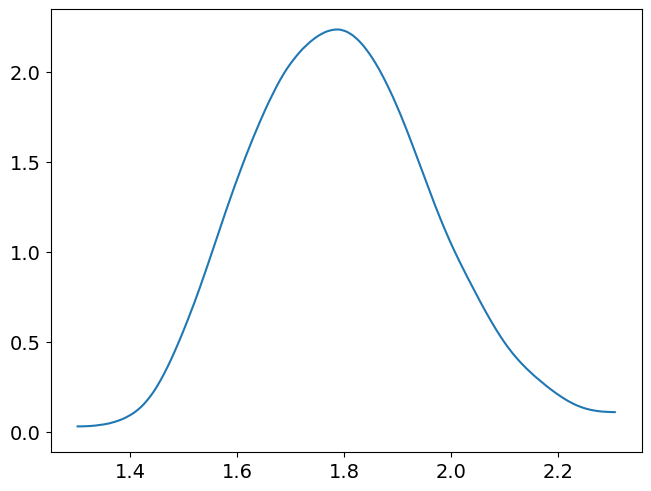

In [18]:
# code 4.2-3
s = np.zeros(1000)
for i in range(1000):
    s[i] = np.prod(np.random.uniform(1, 1.1, 12))

az.plot_kde(s)
plt.show()

(1000,)


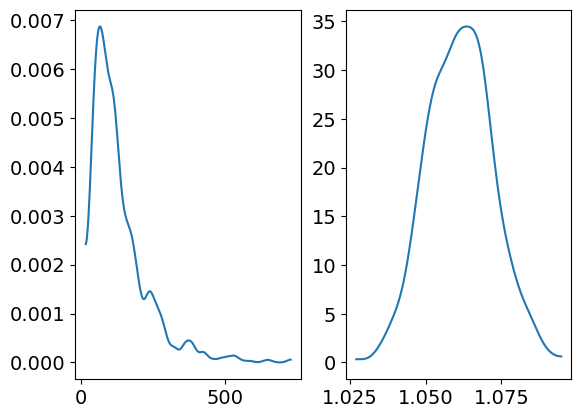

In [25]:
# code 4.4
l = np.random.uniform(1, 2, size=(12, 1000)).prod(0)
s = np.random.uniform(1, 1.01, size=(12, 1000)).prod(0)

fig, ax = plt.subplots(1,2)
az.plot_kde(l, ax=ax[0])
az.plot_kde(s, ax=ax[1])
plt.show()


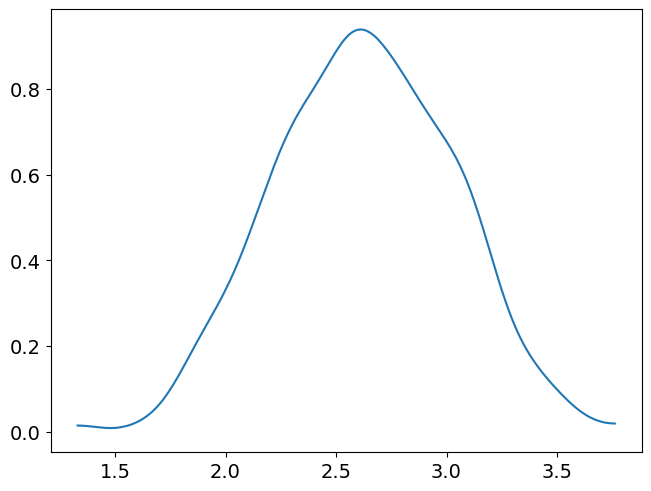

In [29]:
# code 4.5
logbig = np.log(np.random.uniform(1, 1.5, size=(12,1000)).prod(0))

az.plot_kde(logbig)
plt.show()

In [8]:
# code 4.7
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1


In [15]:
d2 = d[d.age >= 18]
d2

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0


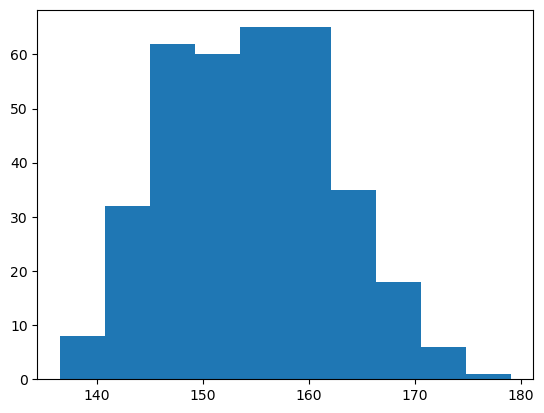

In [28]:
plt.hist(d2.height)
plt.show()

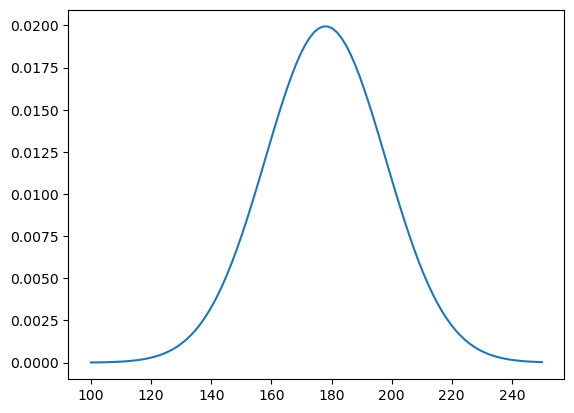

In [33]:
# code 4.12
x = np.linspace(100,250,100)
plt.plot(x, stats.norm.pdf(x, 178, 20))
plt.show()

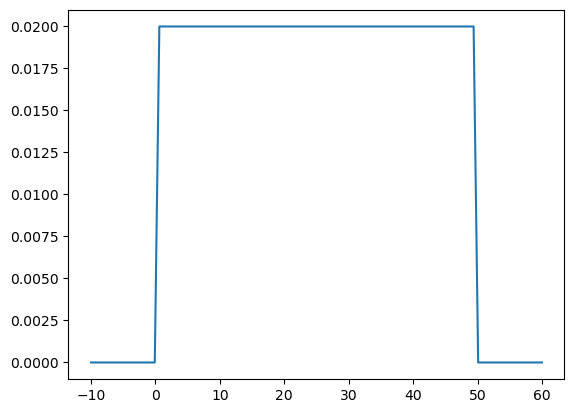

In [34]:
# code 4.13
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50))
plt.show()

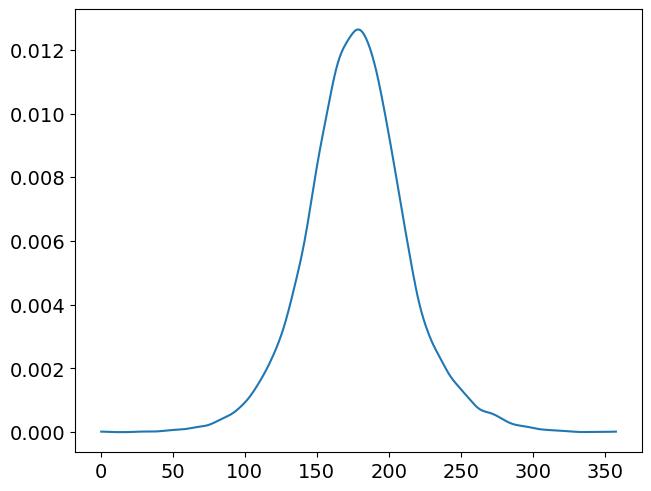

In [43]:
# code 4.14
ns = int(1e4)
sample_mu = stats.norm.rvs(loc=178, scale=20, size=ns)
sample_sigma = stats.uniform.rvs(0, 50, size=ns)
prior_h = stats.norm.rvs(sample_mu, sample_sigma, size=ns)
az.plot_kde(prior_h)
plt.show()

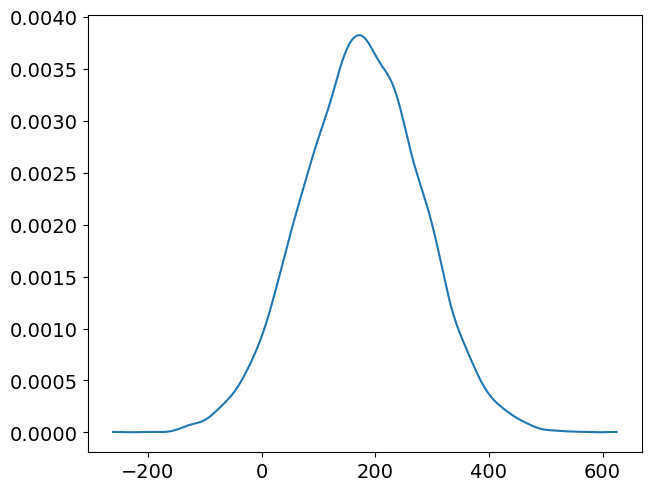

In [44]:
# code 4.15
sample_mu = stats.norm.rvs(loc=178, scale=100, size=ns)
prior_h = stats.norm.rvs(sample_mu, sample_sigma, size=ns)
az.plot_kde(prior_h)
plt.show()

In [46]:
# code 4.16
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))

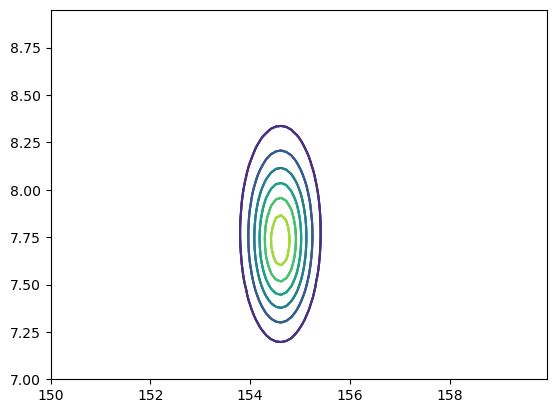

In [50]:
# code 4.17
from scipy.interpolate import griddata
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);
plt.show()

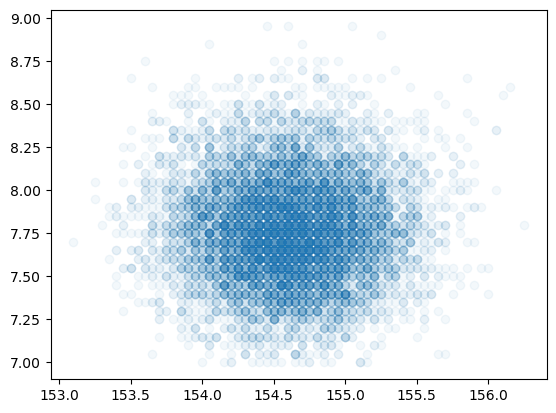

In [66]:
# code 4.19
sample_rows = np.random.choice(np.arange(len(post)), size=ns, replace=True, p=post_prob / post_prob.sum())
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.show()

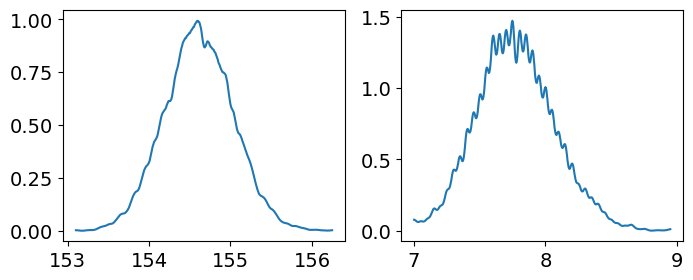

In [70]:
# code 4.21
_, ax = plt.subplots(1,2, figsize=(8,3))
az.plot_kde(sample_mu, ax=ax[0])
az.plot_kde(sample_sigma, ax=ax[1])

plt.show()

In [72]:
# code 4.22
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.8 , 155.35]), array([7.25, 8.35]))

In [77]:
# code 4.23

d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

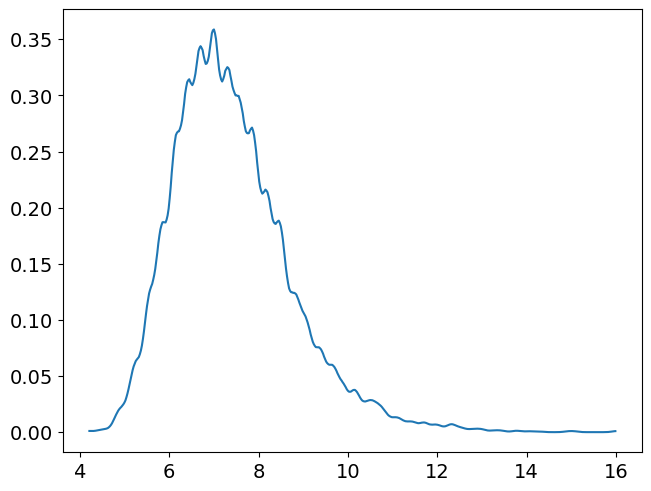

In [95]:
az.plot_kde(sample_sigma2)
plt.show()

In [87]:
# code 4.26
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]

with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2139.42draws/s]


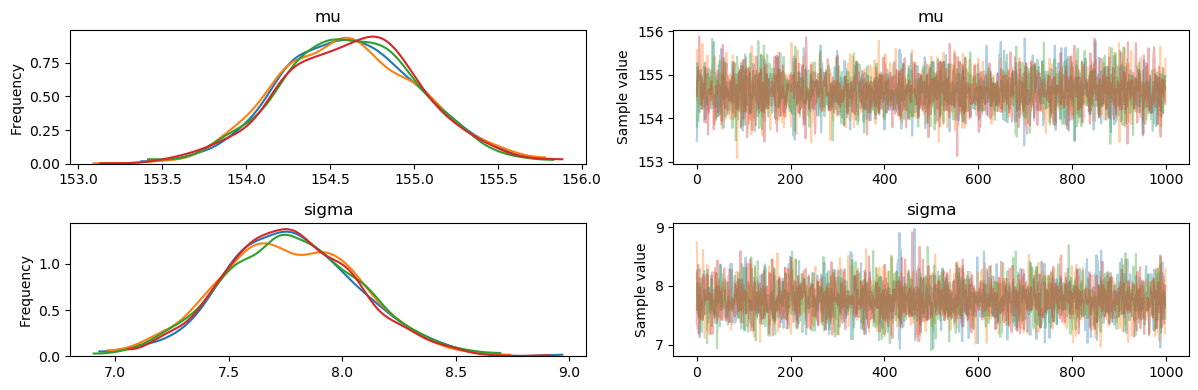

In [92]:
pm.traceplot(trace_4_1)
plt.show()

In [98]:
#az.plot_trace(trace_4_1)
#pm.summary(trace_4_1)
az.summary(trace_4_1, var_names=["mu", "sigma"], round_to=2, kind="stats")

AttributeError: Installed version of ArviZ requires PyMC3>=3.8. Please upgrade with `pip install pymc3>=3.8` or `conda install -c conda-forge pymc3>=3.8`.